In [92]:
from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
import numpy as np
from tqdm import tqdm
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc import waveform
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# $EccTD$ $Eccentricity$

In [17]:
get_available_waveform_origins()

['LAL', 'SXSCatalog', 'LVCNR', 'LVCNR_hack', 'EOB', 'EMRI']

In [18]:
get_load_waveform_docs("LAL")

Help on function load_LAL_waveform in module gw_eccentricity.load_data:

load_LAL_waveform(**kwargs)
    Load waveforms calling the LAL Library.
    
    The kwargs could be the following:
    Run `load_data.get_load_waveform_defaults('LAL')` to see allowed
    keys and defaults.
    
    approximant: str
        Name of the waveform model to be used for generating the waveform.
    q: float
        Mass ratio of the system.
    chi1: 1d array of size 3
        3-element 1d array of spin components of the 1st Black hole.
    chi2: 1d array of size 3
        3-element 1d array of spin components of the 2nd Black hole.
    ecc: float
        Initial eccentricity of the binary at Momega0 (see below).
    mean_ano: float
        Initial Mean anomaly of the binary at Momega0 (see below).
    Momega0: float
        Starting orbital frequency in dimensionless units.
    deltaTOverM: float
        Time steps in dimensionless units.
    physicalUnits: bool
        If True, returns modes in MKS 

[0.07796359 0.07796366 0.07796371 ... 0.21982357 0.21988932 0.21995523]


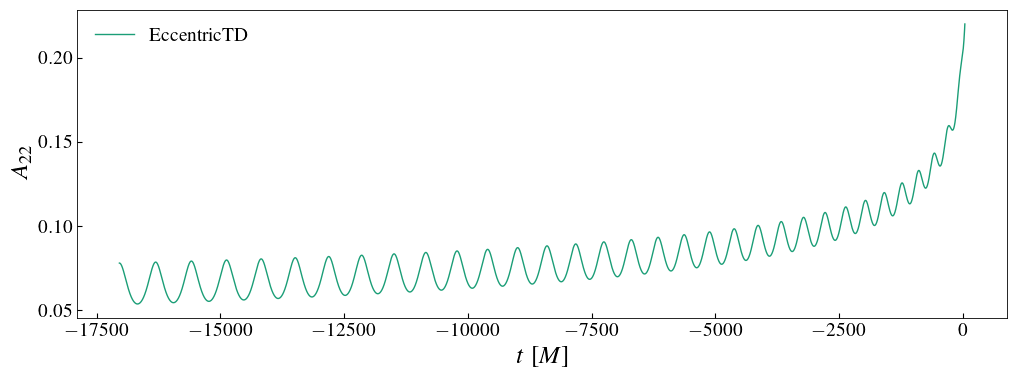

In [19]:
q=2.0
M=30
D=1
e0=0.120
D_SI=D*(10**(6))*PC_SI
M_SI=M*MSUN_SI
M1=q*M/(1+q)
M2=M/(1+q)
mode2polfac=4*(5/(64*np.pi))**(1/2)
kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": 0.0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M,
    "D":D,
    "include_zero_ecc":True,
}
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
use_fancy_plotsettings()
plt.figure(figsize=(12,4))
plt.plot(dataDict["t"]/(M*MTSUN_SI), np.abs(dataDict["hlm"][(2,2)])/(G_SI*M_SI/D_SI/C_SI/C_SI),label=kwargs["approximant"])
# mode2polfac already taken care of in dataDict 
plt.xlabel(labelsDict["t_dimless"])
plt.ylabel(labelsDict["amp22"])
plt.legend()
print(np.abs(dataDict["hlm"][(2,2)])/(G_SI*M_SI/D_SI/C_SI/C_SI))

[0.07796359 0.07796268 0.07795742 ... 0.21756526 0.21857628 0.21963063]
[-1.70823573e+04 -1.70807050e+04 -1.70790528e+04 ... -4.95667671e+00
 -3.30445142e+00 -1.65222613e+00]


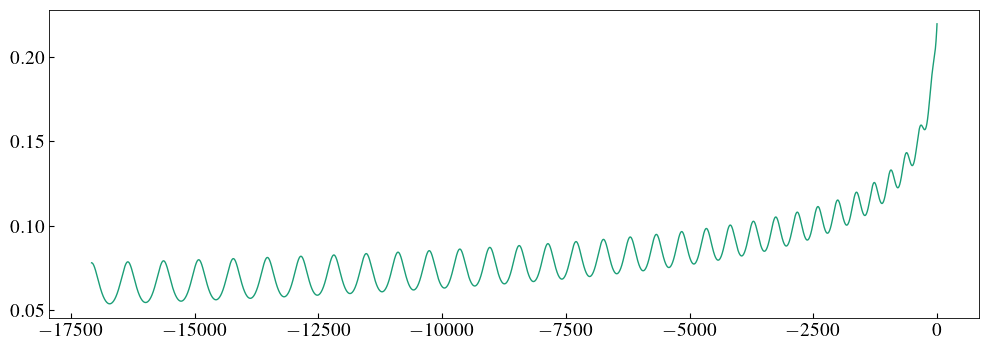

In [20]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=1./4096,f_lower=21.541668606103567,eccentricity=0.120)
plt.figure(figsize=(12,4))
print(abs(hp+1j*hc)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac))
print(hp.sample_times/(M*MTSUN_SI))
plt.plot(hp.sample_times/(M*MTSUN_SI),abs(hp+1j*hc)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac))

In [21]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'AmplitudeFits',
 'FrequencyFits']

In [22]:
#MSUN_SI
#20*(30*MTSUN_SI)

In [109]:
# Measuring ecc at a ref freq
#tref_in = -4000*(M*MTSUN_SI)
fref_in=30
for method in get_available_methods():
    return_dict = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict)
    
    tref_out = return_dict["fref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean_anomaly={mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.135475, mean_anomaly=3.425128
method = Frequency            eccentricity = 0.135465, mean_anomaly=3.437708
method = ResidualAmplitude    eccentricity = 0.135500, mean_anomaly=3.459188
method = ResidualFrequency    eccentricity = 0.135500, mean_anomaly=3.460309
method = AmplitudeFits        eccentricity = 0.135499, mean_anomaly=3.457417
method = FrequencyFits        eccentricity = 0.135500, mean_anomaly=3.460336


In [24]:
help(gwecc_object)

Help on eccDefinitionUsingFrequencyFits in module gw_eccentricity.eccDefinitionUsingFrequencyFits object:

class eccDefinitionUsingFrequencyFits(gw_eccentricity.eccDefinition.eccDefinition)
 |  eccDefinitionUsingFrequencyFits(*args, **kwargs)
 |  
 |  Measure eccentricity by finding extrema location using freq fits.
 |  
 |  Method resolution order:
 |      eccDefinitionUsingFrequencyFits
 |      gw_eccentricity.eccDefinition.eccDefinition
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  FindExtremaNearIdxRef(self, idx_ref, sign, Nbefore, Nafter, K, f_fit, p_initial, bounds, TOL, increase_idx_ref_if_needed=True, refine_extrema=False, verbose=False, pp=None, plot_info='')
 |      given a 22-GW mode (t, phase22, data), identify a stretch of data
 |      [idx_lo, idx_hi] centered roughly around the index idx_ref which
 |      satisfies the following properties:
 |        - The interval [idx_lo, idx_hi] contains Nbefore+Nafter maxima
 |          (if sign==+1) or minimia (if 

[-16309.64315302 -16309.54315302 -16309.44315302 ...   -446.34315302
   -446.24315302   -446.14315302]


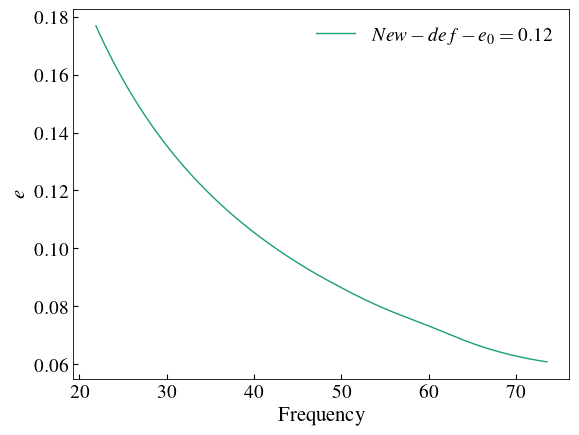

In [25]:
#Diagnostic Plots
method = "ResidualAmplitude"
return_dict = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict)
return_dict
gwecc_object = return_dict["gwecc_object"]
#plt.figure(figsize=(6,6))
#fig, ax=gwecc_object.plot_eccentricity()
Time_data=gwecc_object.get_omega22_average()[0]  #doing this to extract the time values
Omega_avg=gwecc_object.get_omega22_average()[1]
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict)
ECC_data_new=(return_dict1["eccentricity"])
#plt.plot(Time_data/(M*MTSUN_SI),ECC_data_new,label=r"$New-def-e_0=0.12$")
plt.plot(Omega_avg/(2*PI),ECC_data_new,label=r"$New-def-e_0=0.12$")
plt.legend()
#plt.xlabel(r"$t/M$",size=15)
plt.xlabel(r'Frequency',size=15)
plt.ylabel(r'$e$',size=15)
print(Time_data/(M*MTSUN_SI))
#plt.savefig('New_e-t.png',dpi=300)
plt.savefig('New_e-f.png',dpi=300)

# $NR$ $Eccentricity$

In [26]:
#origin = "SXSCatalog"
#get_load_waveform_defaults(origin)

#export LAL_DATA_PATH='home/pratul/Downloads/'  #first run this in command line then run jupyter notebook

In [27]:
#kwargs = {"filepath": '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5',
         #"metadata_path": '/home/pratul/Downloads/metadata.txt',
         #"include_zero_ecc":True,
         #"zero_ecc_approximant": "SEOBNRv4HM"}

#dataDict1 = load_waveform(origin, **kwargs)
##plt.figure(figsize=(12,4))
#plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2,2)]),label=origin+' '+str(1364))
#plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2,2)]),label=kwargs["zero_ecc_approximant"] + " e = 0")
#plt.xlim(dataDict["t"][0],200)
#plt.xlabel(labelsDict["t_dimless"])
#plt.ylabel(labelsDict["amp22"])
#plt.legend(loc="upper left")

In [28]:
# Measuring ecc at a ref freq
#tref_in = -1000
#for method in get_available_methods():
    #return_dict = measure_eccentricity(tref_in=tref_in,method=method,dataDict=dataDict1)
    
    #tref_out = return_dict["tref_out"]
    #eccentricity = return_dict["eccentricity"]
    #mean_anomaly = return_dict["mean_anomaly"]
    #gwecc_object = return_dict["gwecc_object"]
    #print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean_anomaly={mean_anomaly:.6f}")

In [29]:
#Diagnostic Plots
#method = "ResidualAmplitude"
#tref_in=-1000
#return_dict = measure_eccentricity(tref_in=tref_in,method=method,dataDict=dataDict1)

#gwecc_object = return_dict["gwecc_object"]
#fig, ax=gwecc_object.make_diagnostic_plots()
#plt.savefig('NR.pdf')

# Old ecc definition (LALINSPIRALECCTD)


In [30]:
import lalsimulation as lalsim
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from ctypes import *
import numpy as np
import matplotlib.pyplot as plt
import math
import lal

In [31]:
#conversion from freq param x to freq in Hz for (2,2) mode
def f(u,mass):
    return math.pow(u,3.0/2.0)/(MTSUN_SI * mass * lal.PI)

In [32]:
#conversion from freq in Hz to freq param
def xconv(f,mass):
    return (MTSUN_SI * mass * lal.PI * f)**(2/3)

In [33]:
q=q
Mtot=M
M1=q*Mtot/(1+q) * MSUN_SI
M2=Mtot/(1+q) * MSUN_SI
M=(M1+M2)/MSUN_SI
#eref = 2e-6
e_min=0.120
n=0
phi_ref=0
xmin=0.046415888336127795 #obtained using Momega0=0.01
xref=0.075

In [34]:
print(f(0.046415888336127795,30)) 
0.01**(2/3)   #gw_eccentricity uses Momega0. so freq param x=(Momega0)**(2/3). 

21.541668606103567


0.046415888336127795

In [35]:
v, et, l, lmda, u, phi = lalsim.SimInspiralEccentricTDPNEvolveOrbit(phiRef=phi_ref,deltaT=1/2048,m1=M1, m2=M2, f_min=f(xmin,M), fRef=f(xref,M), e_min=e_min,O=-1)

In [36]:
for i in range(0,phi.data.length):
    if phi.data.data[i]==phi_ref:
        idx=i
        
print(phi.data.data[idx])
print(et.data.data[idx])
print(f(xmin,M))
print(f(xref,M))

0.0
0.052222187391193
21.541668606103567
44.245716831989206


In [37]:
time1=np.empty(phi.data.length)
time1[0] = phi.epoch
for i in range(1,phi.data.length):
    time1[i]=time1[i-1]+et.deltaT

print(time1[0]/(Mtot*MTSUN_SI))    

-17084.00948527026


5170


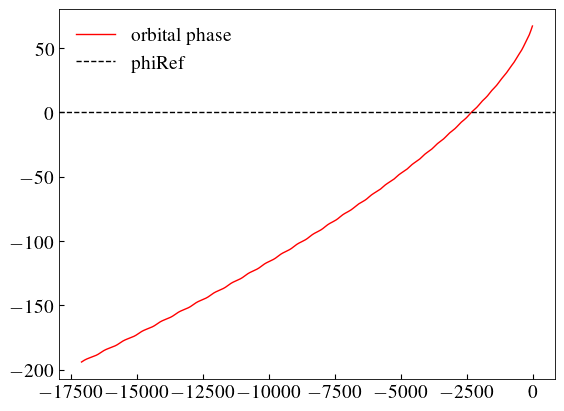

In [38]:
plt.plot(time1/(Mtot*MTSUN_SI),phi.data.data,'r',label='orbital phase')
plt.axhline(y=0,color='k',ls='--',label='phiRef')
plt.legend()
print(phi.data.length)

In [39]:
print(phi.deltaT)

0.00048828125


In [40]:
omega=(np.gradient(phi.data.data))/phi.deltaT
freq=omega/(2*PI)
print(phi.data.data)

[-193.9492212  -193.90328411 -193.85736372 ...   66.80153819   67.01300134
   67.22749995]


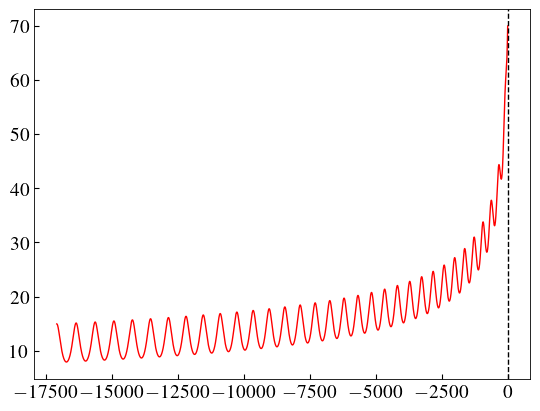

In [41]:
plt.plot(time1/(Mtot*MTSUN_SI),freq,'r',label='orbital frequency')
plt.axvline(x=time1[idx],color='k',ls='--',label='ref_time')

[-1.70840095e+04 -1.70807050e+04 -1.70774006e+04 ... -9.91334835e+00
 -6.60889777e+00 -3.30444719e+00]


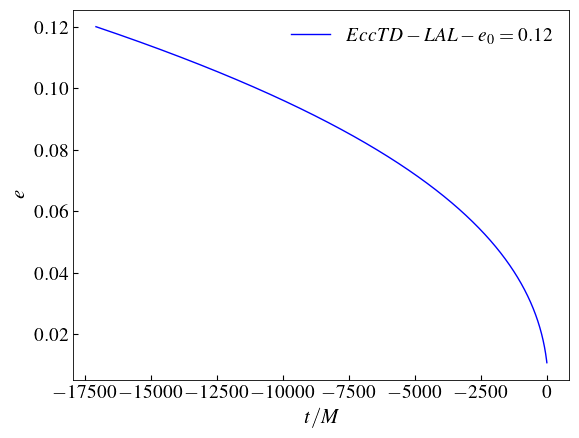

In [91]:
plt.plot(time1/(Mtot*MTSUN_SI),et.data.data,'b',label=r'$EccTD-LAL-e_0=0.12$')
#plt.axhline(y=et.data.data[idx],color='k',ls='--',label='e_ref')
#plt.axvline(x=-4000,color='k',ls='--',label='t_ref')
print(time1/(Mtot*MTSUN_SI))
plt.xlabel(r'$t/M$',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
plt.savefig('LAL_e-t.png',dpi=300)


In [79]:
#help(find_peaks)

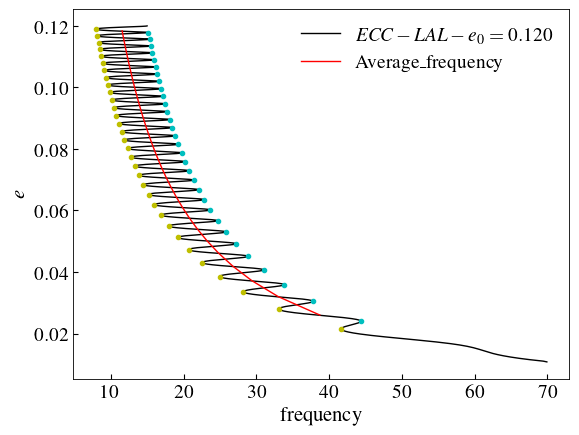

In [89]:
indices_crest=find_peaks(freq,prominence=1)[0]
indices_trough=find_peaks(-freq,prominence=1)[0]
freq_crest=freq[indices_crest]
freq_trough=freq[indices_trough]
e_crest=(et.data.data)[indices_crest]
e_trough=(et.data.data)[indices_trough]
ff=np.delete(freq[indices_trough],-1)
ee=np.delete((et.data.data)[indices_trough],-1)
avg_freq=0.5*(np.array(freq_crest)+np.array(ff))
avg_et=0.5*(np.array(e_crest)+np.array(ee))
plt.plot(freq,et.data.data,'k-',label=r'$ECC-LAL-e_0=0.120$')
plt.plot(freq_crest,e_crest,'co',markersize=3)
plt.plot(freq_trough,e_trough,'yo',markersize=3)
plt.plot(avg_freq,avg_et,'r-',linewidth=1,label='Average_frequency')
plt.xlabel('frequency',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
plt.savefig('LAL_e-f.png',dpi=300)

# Old Ecc defintion (Moore et. al.)

In [44]:
%run GW_functions.ipynb

In [45]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    fVec_PN=waveform.utils.frequency_from_polarizations(hpVec_PN, hcVec_PN)
    return phase_EccTD, tVec_PN

10311
[-17082.35726421 -17080.70503892 -17079.05281363 ...   -234.61599189
   -232.9637666    -231.31154131]


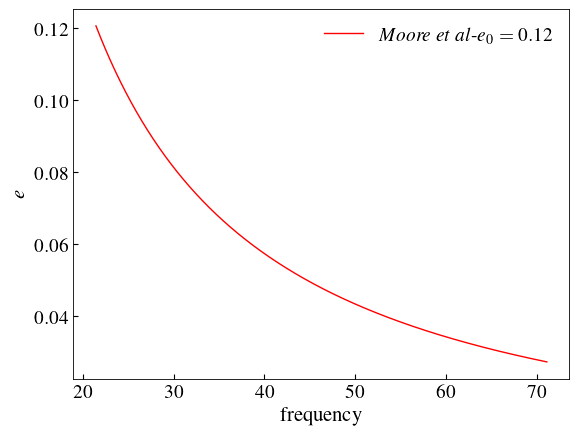

In [46]:
eta=q/(1+q)**2
EulerGamma=0.577215664901
phase_EccTD, tVec_PN= PNparams(M,q,D,21.541668606103567,e0,1.0/4096)
tC_NR=0
M_new=1
x0=xlow=0.046415888336127795
xi0=x0**(3/2)
v0=xi0**(1/3)
theta=((5*M_new/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M_new/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta,theta0,e0,M_new,eta)
plotIdx2=np.nonzero(fVec>0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M_new*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec=xVec[xband]
maxPNidx=len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
print(len(fVec))
Ecc_Moore=[]
for i in xVec:
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    Ecc_Moore.append(e)

time=tVec_PN
print(time[:10200])
#np.delete(Ecc_Moore,-1)
#plt.plot(time[:10200],Ecc_Moore[:10200],'r-',label=r'$Moore$ $et$ $al$-$e_0=0.12$')
plt.plot(fVec[:10200]/(M*MTSUN_SI),Ecc_Moore[:10200],'r-',label=r'$Moore$ $et$ $al$-$e_0=0.12$')
#plt.xlabel(r't/M',size=15)
plt.xlabel(r'frequency',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
#plt.savefig('Moore_e-t.png',dpi=300)
plt.savefig('Moore_e-f.png',dpi=300)
#plt.ylim(0,0.13)

In [47]:
a=np.array([-1,2,3])
np.delete(a,2)

array([-1,  2])

In [94]:
intrp_Moore = interp1d(fVec[:10200]/(M*MTSUN_SI),Ecc_Moore[:10200],kind='cubic',fill_value='extrapolate')
intrp_LAL = interp1d(avg_freq,avg_et,kind='cubic',fill_value='extrapolate')

100%|███████████████████████████████████████████| 38/38 [02:21<00:00,  3.73s/it]


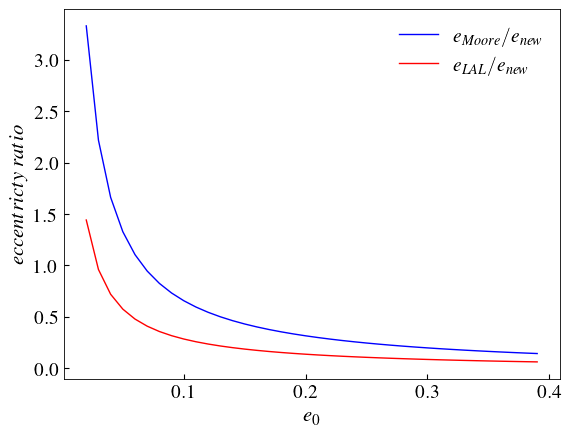

In [130]:
ecc0=np.arange(0.02,0.40,0.01)
ecc_comp_Moore_new=[]
ecc_comp_LAL_new=[]
ecc_comp1_Moore_new=[]
ecc_comp1_LAL_new=[]
fref_in=40
for i in tqdm(ecc0):
    kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": i,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": 0.0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": Mtot,
    "D":D,
    "include_zero_ecc":True,
    }
    origin = "LAL"
    dataDict_new = load_waveform(origin, **kwargs)
    method = "ResidualAmplitude"
    return_dict_new = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict_new)
    ecc_new=return_dict_new['eccentricity']
    ecc_LAL=intrp_LAL(fref_in)
    ecc_Moore=intrp_Moore(fref_in)
    #print(ecc_new,ecc_LAL,ecc_Moore)
    #print('\n')
    ecc_comp_Moore_new.append(ecc_Moore/ecc_new)
    ecc_comp_LAL_new.append(ecc_LAL/ecc_new)
    ecc_comp1_Moore_new.append(ecc_new-ecc_Moore)
    ecc_comp1_LAL_new.append(ecc_new-ecc_LAL)
    
plt.plot(ecc0,ecc_comp_Moore_new,'b',label=r'$e_{Moore}/e_{new}$')
plt.plot(ecc0,ecc_comp_LAL_new,'r',label=r'$e_{LAL}/e_{new}$')
plt.xlabel(r'$e_0$',size=15)
plt.ylabel(r'$eccentricty$ $ratio$',size=15)
plt.legend()
#plt.savefig('ecc_ratio.png',dpi=300) 

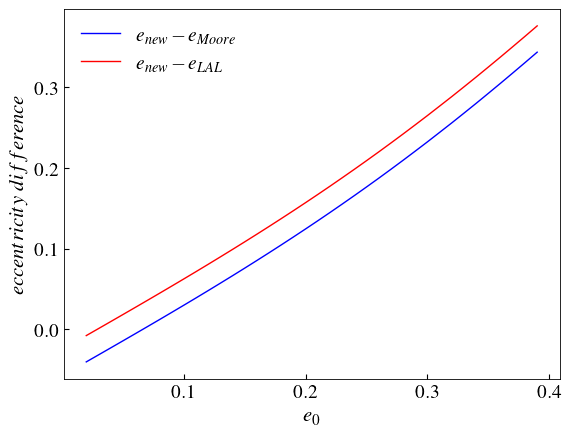

In [131]:
plt.plot(ecc0,ecc_comp1_Moore_new,'b',label=r'$e_{new}-e_{Moore}$')
plt.plot(ecc0,ecc_comp1_LAL_new,'r',label=r'$e_{new}-e_{LAL}$')
plt.xlabel(r'$e_0$',size=15)
plt.ylabel(r'$eccentricity$ $difference$',size=15)
plt.legend()
#plt.savefig('ecc_difference.png',dpi=300)